In [1]:
import wandb
import wandb.apis
import pandas as pd
from typing import *
import seaborn as sns
import matplotlib

api = wandb.Api()

In [25]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "match" in run.summary:
        d = run.config["sparsity"].copy()
        d.update(**d.pop("importance", {}))
        assert run.summary["count"] == 1000
        d["match"] = run.summary["match"]
        d["rougeL"] = run.summary.get("rougeL")
        d["model"] = run.config["model"]
        d["task"] = run.config["task"]["name"]
        return d

def load_sweep(name: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"config.name": name}
        )
    )))

df = (pd.concat([load_sweep("RMOE-51-baselines"), load_sweep("RMOE-52-eviction-v3")])
    .reset_index(drop=True)
    .pipe(lambda d: d[d.task == "squad"])
    .pipe(lambda d: d[d.model == "EleutherAI/pythia-1.4b"])
    .pipe(lambda d: d[d.name.isin(["eviction", "dense"])])
    .pipe(lambda d: d[d.local_k.isna() | (d.local_k*4 == d.k)])
    .pipe(lambda d: d[d.k.isna() | (d.k >= 128)])
    .drop(columns=["task", "name", "add_avg", "apply_after_softmax", "local_k"])
)
len(df)

73

In [28]:
def technique(s: pd.Series) -> str:
    if pd.isna(s.k):
        return "dense"
    if pd.isna(s.metric):
        return "original"
    result = f"{s.metric}"
    if "threshold" in s.metric:
        result += f"/{s.metric_threshold}"
    result += f" - {s.reduction}"
    if s.reduction == "decaymax":
        result += f"/{int(s.reduction_decay)}"
    return result

display(df.assign(technique=df.apply(technique, axis=1))
 .pipe(lambda d: d[d.technique != "dense"])
 .pivot(index=["technique"], columns="k", values="match")
 .sort_values([256], ascending=False)
)

k,128.0,256.0,512.0,1024.0
technique,,,,
global_threshold/1.0 - decaymax/1000,0.349,0.386,0.401,0.418
threshold/1.0 - decaymax/1000,0.350,0.385,0.401,0.416
threshold/0.5 - decaymax/1000,0.347,0.383,0.395,0.417
global_threshold/0.5 - decaymax/1000,0.336,0.378,0.398,0.420
weight - decaymax/200,0.349,0.371,0.394,0.417
weight - decaymax/1000,0.323,0.359,0.387,0.411
weight - mean,0.290,0.329,0.367,0.406
weight - sum,0.307,0.327,0.361,0.401
original,0.270,0.294,0.335,0.383


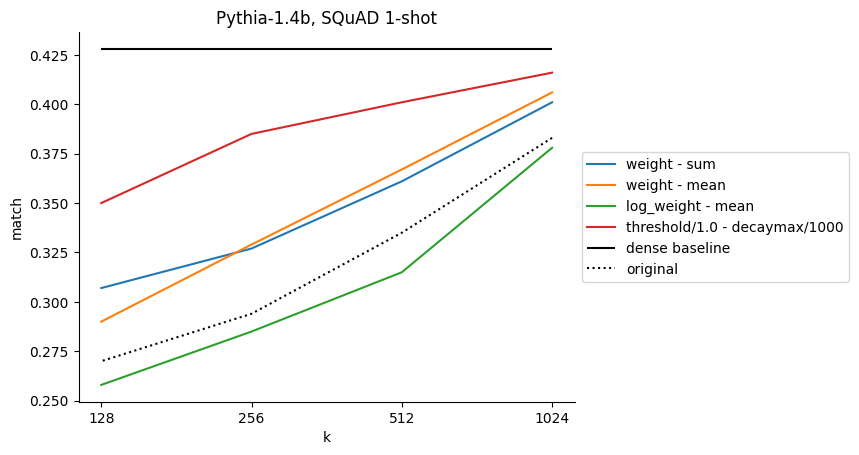

In [29]:
techniques = ["weight - sum", "weight - mean", "log_weight - mean", "threshold/1.0 - decaymax/1000"]
d = df.assign(technique=df.apply(technique, axis=1))
ax = sns.lineplot(data=d.pipe(lambda d: d[d.technique.isin(techniques)]), y="match", x="k", hue="technique", hue_order=techniques)
ax.hlines(df[df.k.isna()].match, 128, 1024, "k", label="dense baseline")
ax.plot(d[d.technique=="original"].k, d[d.technique=="original"].match, "k:", label="original")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
ax.set_title("Pythia-1.4b, SQuAD 1-shot")
sns.despine(ax=ax)